# Exploratory Data Analysis
## Ames Housing Data 

This is the first of two notebooks for the Ames Housing data project. The aim of this project is to create a regression model based on the Ames Housing Dataset that predicts the price of a house at sale.
Here, I acquaint myself with the data, examine the features, and visualize relationships within the dataset (e.g., correlation, distribution ) with respect to the target variable `SalesPrice`.

# Contents
- [Import Libraries and Datasets](#Import-Libraries-and-Datasets)
- [Initial Examination and Cleanup of Data](#Initial-Examination-and-Cleanup-of-Data)
- [Feature and Relationship Examination](#Feature-and-Relationship-Examination)
- [Final Processing and Export](#Final-Processing-and-Export)

# Import Libraries and Datasets

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

from scipy import stats
import statsmodels.api as sm

%matplotlib inline

from EDA_CustomClass_ames import CleanExplore

In [2]:
# 'og' is original, unaltered dataset saved to memory
train_og = pd.read_csv('./datasets/train.csv')
test_og = pd.read_csv('./datasets/test.csv')

In [3]:
# create copies of datasets that we will work with
train = train_og.copy()
test = test_og.copy()

In [4]:
# instantiate instance for CustomClass
train_cc = CleanExplore(train)

# Initial Examination and Cleanup of Data

### Snapshot
*.snapshot() is a CustomClass I created to quickly view the basics of a dataframe.*

In [5]:
train_cc.snapshot()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

### Treat Outliers
From [De Cock's paper](http://jse.amstat.org/v19n3/decock.pdf):
> *There are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these points). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students.*

Per De Cock's recommendation, we'll removed any observations with `Gr Liv Area > 4_000`

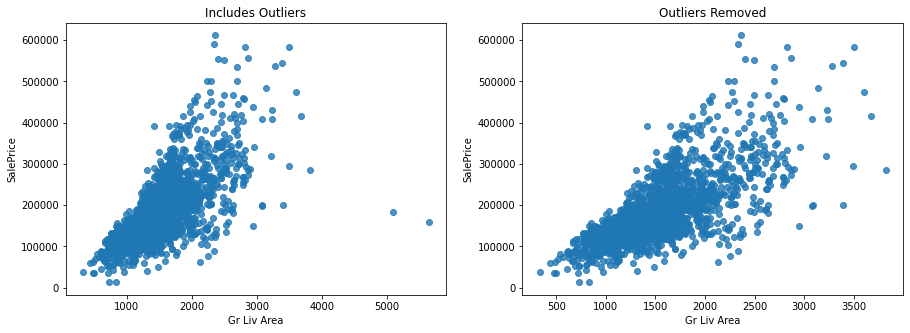

In [6]:
# remove outliers
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['Gr Liv Area'], y=train['SalePrice'], fit_reg=False).set_title("Includes Outliers")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['Gr Liv Area']>4000)].index)
g = sns.regplot(x=train['Gr Liv Area'], y=train['SalePrice'], fit_reg=False).set_title("Outliers Removed")

# https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5

### Treat `NaN`s

In [7]:
# 1-column heatmap

In [8]:
train_nan = train.isnull().sum().sort_values()
train_nan

Id                 0
Sale Type          0
Heating QC         0
Central Air        0
Electrical         0
                ... 
Fireplace Qu    1000
Fence           1649
Alley           1909
Misc Feature    1985
Pool QC         2041
Length: 81, dtype: int64

In [9]:
train.shape

(2049, 81)

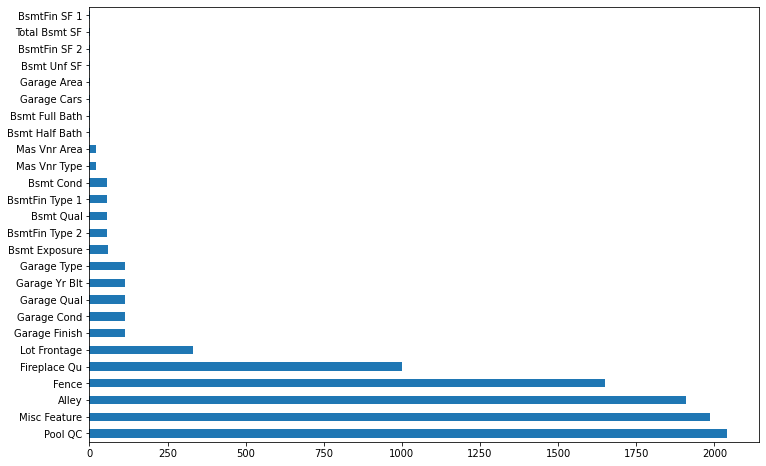

In [10]:
# visualize nans
# get rid of all the values with 0 missing values
train_nan = train_nan.drop(train_nan[train_nan == 0].index).sort_values(ascending=False)
plt.subplots(figsize =(12, 8))
train_nan.plot(kind='barh');

In [11]:
train.shape

(2049, 81)

In [12]:
# per data description, these are categorical variables
# NaNs should be "None"
# e.g., Pool Quality NA is "No Pool"
# converting to dtype: object in case I want to make dummies

nans_as_None = train[['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu', 
                     'Garage Cond', 'Garage Qual', 'Garage Finish', 'Garage Type', 
                     'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Bsmt Cond', 'Bsmt Qual', 
                     'Mas Vnr Type']]

for feat in nans_as_None:
    train[feat] = train[feat].fillna("None")

In [13]:
# per data description, these are numerical varialbes
# filling NaNs w/ 0 (to imply False or doesn't exist)
# e.g., Bsmt Full Bath == 0 means does not have Bsmt Full Bath
# Garage Yr Blt == 0 means home doesn't have garage
nans_as_0 = train[['Bsmt Full Bath', 'Bsmt Half Bath', 'Bsmt Unf SF', 'BsmtFin SF 1', 
                  'BsmtFin SF 2', 'Garage Area', 'Garage Cars', 'Garage Yr Blt',
                  'Total Bsmt SF', 'Mas Vnr Area']]

for feat in nans_as_0:
    train[feat] = train[feat].fillna(0)

Treat: `'Lot Frontage'`
- Because lot frontage has a relatively high number of `NaN`s (330), I'm not comfortable dropping the `NaN`s entirely.
- I will impute with the median (68) since it is relatively close to the mean (~68.9)
    

In [14]:
train['Lot Frontage'].describe()

count    1719.000000
mean       68.878999
std        22.472112
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: Lot Frontage, dtype: float64

In [15]:
train['Lot Frontage'].replace(np.nan, train['Lot Frontage'].median(), inplace=True)

In [16]:
train.isnull().sum()

Id              0
PID             0
MS SubClass     0
MS Zoning       0
Lot Frontage    0
               ..
Misc Val        0
Mo Sold         0
Yr Sold         0
Sale Type       0
SalePrice       0
Length: 81, dtype: int64

### Treat Non-Numeric

In [17]:
# first, check for all datatypes
pd.set_option('display.max_rows', 85)
train.dtypes.sort_values()
#https://stackoverflow.com/questions/23168416/pandas-printing-all-dtypes

Id                   int64
2nd Flr SF           int64
Low Qual Fin SF      int64
Gr Liv Area          int64
Full Bath            int64
Half Bath            int64
Bedroom AbvGr        int64
Kitchen AbvGr        int64
TotRms AbvGrd        int64
1st Flr SF           int64
Fireplaces           int64
Open Porch SF        int64
Enclosed Porch       int64
3Ssn Porch           int64
Screen Porch         int64
Pool Area            int64
Misc Val             int64
Mo Sold              int64
Yr Sold              int64
Wood Deck SF         int64
Year Remod/Add       int64
SalePrice            int64
Lot Area             int64
PID                  int64
MS SubClass          int64
Overall Qual         int64
Year Built           int64
Overall Cond         int64
Total Bsmt SF      float64
BsmtFin SF 2       float64
Garage Cars        float64
BsmtFin SF 1       float64
Bsmt Full Bath     float64
Bsmt Unf SF        float64
Lot Frontage       float64
Garage Yr Blt      float64
Mas Vnr Area       float64
B

In [19]:
# create dummy columns for all data in case we want to examine later
# in same line of code, convert featurs to ints
train_dummies = pd.get_dummies(train).astype(int)
# documentation:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

In [20]:
train_dummies.shape

(2049, 304)

In [21]:
pd.set_option('display.max_rows', 400)
train_dummies.dtypes

Id                      int64
PID                     int64
MS SubClass             int64
Lot Frontage            int64
Lot Area                int64
Overall Qual            int64
Overall Cond            int64
Year Built              int64
Year Remod/Add          int64
Mas Vnr Area            int64
BsmtFin SF 1            int64
BsmtFin SF 2            int64
Bsmt Unf SF             int64
Total Bsmt SF           int64
1st Flr SF              int64
2nd Flr SF              int64
Low Qual Fin SF         int64
Gr Liv Area             int64
Bsmt Full Bath          int64
Bsmt Half Bath          int64
Full Bath               int64
Half Bath               int64
Bedroom AbvGr           int64
Kitchen AbvGr           int64
TotRms AbvGrd           int64
Fireplaces              int64
Garage Yr Blt           int64
Garage Cars             int64
Garage Area             int64
Wood Deck SF            int64
Open Porch SF           int64
Enclosed Porch          int64
3Ssn Porch              int64
Screen Por

# Feature and Relationship Examination
---

### Target Variable

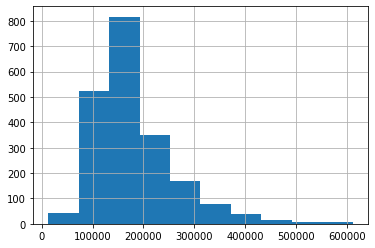

In [24]:
train_dummies['SalePrice'].hist();

**Note** the positive skewed distribution of `SalePrice`. In the next notebook, *02_Model*, I will take the log and/or (log+1) transformation of the target to make a more normal distribution.

### Basic Correlation

In [38]:
# display correlation for all features
pd.set_option('display.max_rows', 400)
train_dummies.corr().SalePrice.sort_values(ascending=False)

SalePrice               1.000000
Overall Qual            0.803462
Gr Liv Area             0.719463
Total Bsmt SF           0.665116
Garage Area             0.655097
1st Flr SF              0.648252
Garage Cars             0.648227
Bsmt Qual_Ex            0.589810
Year Built              0.572405
Kitchen Qual_Ex         0.555131
Year Remod/Add          0.550872
Full Bath               0.538225
Foundation_PConc        0.529500
Mas Vnr Area            0.511273
TotRms AbvGrd           0.509775
Exter Qual_Ex           0.500425
Fireplaces              0.473783
BsmtFin Type 1_GLQ      0.464266
Heating QC_Ex           0.453582
Neighborhood_NridgHt    0.448639
Exter Qual_Gd           0.446721
BsmtFin SF 1            0.446103
Garage Finish_Fin       0.423776
Fireplace Qu_Gd         0.385490
Bsmt Exposure_Gd        0.379081
Sale Type_New           0.360599
Garage Type_Attchd      0.358104
Exterior 1st_VinylSd    0.342156
Open Porch SF           0.338545
Lot Frontage            0.338280
Exterior 2

In [25]:
# view top20 positively correlated features to SalesPrice
train_dummies.corr().SalePrice.sort_values(ascending=False).head(20)

SalePrice               1.000000
Overall Qual            0.803462
Gr Liv Area             0.719463
Total Bsmt SF           0.665116
Garage Area             0.655097
1st Flr SF              0.648252
Garage Cars             0.648227
Bsmt Qual_Ex            0.589810
Year Built              0.572405
Kitchen Qual_Ex         0.555131
Year Remod/Add          0.550872
Full Bath               0.538225
Foundation_PConc        0.529500
Mas Vnr Area            0.511273
TotRms AbvGrd           0.509775
Exter Qual_Ex           0.500425
Fireplaces              0.473783
BsmtFin Type 1_GLQ      0.464266
Heating QC_Ex           0.453582
Neighborhood_NridgHt    0.448639
Name: SalePrice, dtype: float64

In [26]:
# create list of top5 positively correlated features
top_pos_corr = train_dummies[['Overall Qual', 
                             'Gr Liv Area',
                             'Total Bsmt SF', 
                             'Garage Area',
                             '1st Flr SF']]

In [27]:
# view variable negatively correlated features to SalesPrice
train_dummies.corr().SalePrice.sort_values(ascending=False).tail(20)

Garage Cond_None     -0.230894
Garage Finish_None   -0.230894
Garage Qual_None     -0.230894
Garage Type_None     -0.231030
Roof Style_Gable     -0.250019
PID                  -0.255068
Paved Drive_N        -0.273661
Central Air_N        -0.277425
MS Zoning_RM         -0.282032
Bsmt Exposure_No     -0.293542
Lot Shape_Reg        -0.306707
Heating QC_TA        -0.343692
Foundation_CBlock    -0.355768
Garage Type_Detchd   -0.370485
Mas Vnr Type_None    -0.411630
Garage Finish_Unf    -0.432476
Bsmt Qual_TA         -0.457260
Fireplace Qu_None    -0.486208
Kitchen Qual_TA      -0.541265
Exter Qual_TA        -0.600974
Name: SalePrice, dtype: float64

In [28]:
# create variable of top5 negatively correlated features
top_neg_corr = train_dummies[['Exter Qual_TA', 
                              'Kitchen Qual_TA', 
                              'Fireplace Qu_None', 
                              'Bsmt Qual_TA', 
                              'Garage Finish_Unf']]
top_neg_corr.dtypes

Exter Qual_TA        int64
Kitchen Qual_TA      int64
Fireplace Qu_None    int64
Bsmt Qual_TA         int64
Garage Finish_Unf    int64
dtype: object

### Correlation & Distribution (Visualization)

#### Pairplots

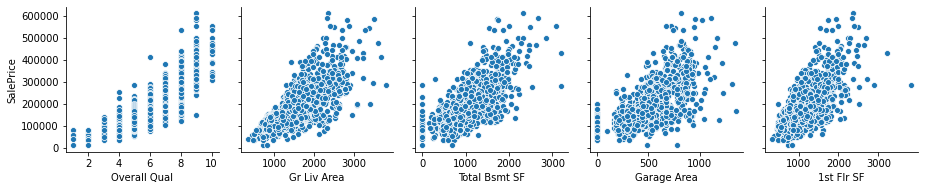

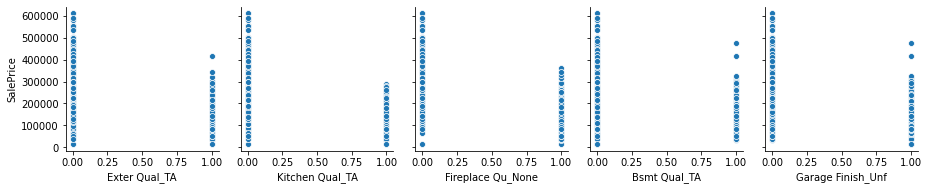

In [29]:
# pairplot for top5 positively correlated features
sns.pairplot(train_dummies, x_vars=['Overall Qual', 
                                     'Gr Liv Area',
                                     'Total Bsmt SF', 
                                     'Garage Area',
                                     '1st Flr SF'], 
                            y_vars=['SalePrice']);

# pairplot for top5 negatively correlated features
sns.pairplot(train_dummies, x_vars=['Exter Qual_TA', 
                                    'Kitchen Qual_TA',
                                    'Fireplace Qu_None', 
                                    'Bsmt Qual_TA',
                                    'Garage Finish_Unf'], 
                            y_vars=['SalePrice']);

#### Histograms

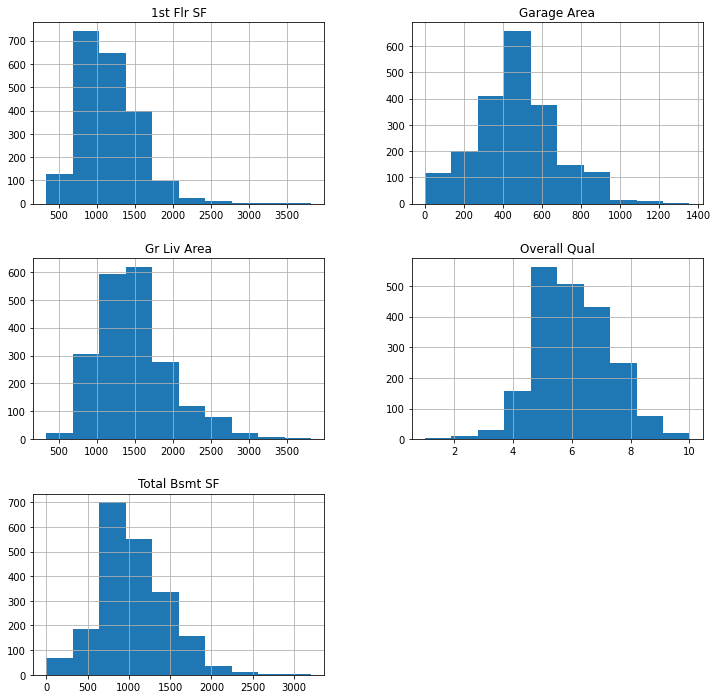

In [36]:
top_pos_corr.hist(figsize=(12, 12));

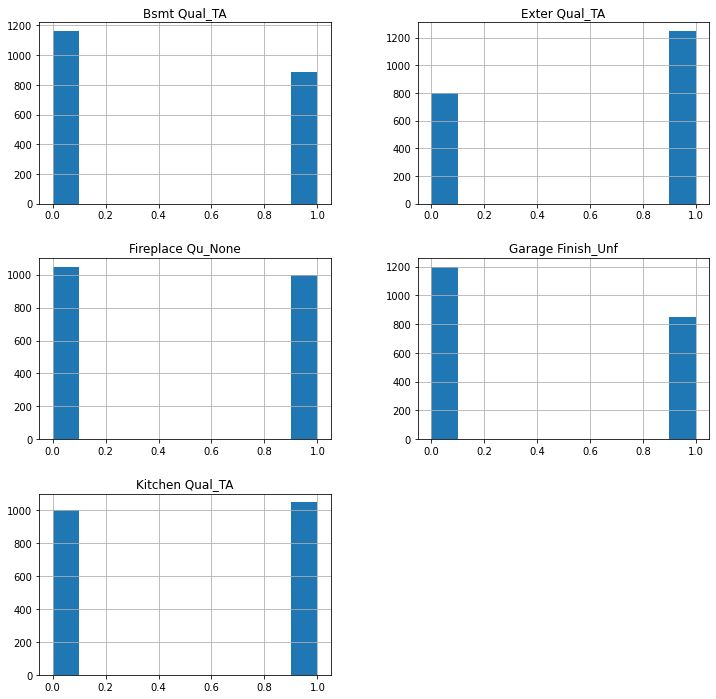

In [35]:
top_neg_corr.hist(figsize=(12, 12));

# Final Processing and Export
### Process `test.csv` the same way I processed `training.csv`
---

In [43]:
print(f'clean train shape: {train_dummies.shape}')
print(f'to clean test shape: {test.shape}')

clean train shape: (2049, 304)
to clean test shape: (878, 80)


### Review outliers
- Index `170` and `463` have `Gr Liv Area` > 4,000
- Since we can't remove these values from the test set, we may have to normalize in our model.

In [42]:
test[(test['Gr Liv Area']>4000)]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
170,1761,528320050,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,...,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD
463,1768,528351010,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,1,2007,WD


### Treat `NaN`s
- The methodology for treating `NaN`s in `test` follows the same methodology for `train` described above.

In [47]:
test.isnull().sum().sort_values(ascending=False)

Pool QC            874
Misc Feature       837
Alley              820
Fence              706
Fireplace Qu       422
Lot Frontage       160
Garage Cond         45
Garage Qual         45
Garage Yr Blt       45
Garage Finish       45
Garage Type         44
Bsmt Exposure       25
BsmtFin Type 1      25
Bsmt Qual           25
BsmtFin Type 2      25
Bsmt Cond           25
Mas Vnr Area         1
Mas Vnr Type         1
Electrical           1
Overall Cond         0
Exter Qual           0
Exter Cond           0
Foundation           0
Exterior 2nd         0
Exterior 1st         0
Roof Matl            0
Roof Style           0
Year Remod/Add       0
Year Built           0
Sale Type            0
Overall Qual         0
House Style          0
Bldg Type            0
Condition 2          0
Condition 1          0
Land Slope           0
Lot Config           0
Utilities            0
Land Contour         0
Lot Shape            0
Street               0
Lot Area             0
MS Zoning            0
MS SubClass

In [50]:
# categorical variables; NaNs to "None"
nans_as_None_test = test[['Pool QC', 
                          'Misc Feature', 
                          'Alley', 
                          'Fence', 
                          'Fireplace Qu', 
                          'Garage Cond', 
                          'Garage Qual', 
                          'Garage Finish', 
                          'Garage Type',
                          'Bsmt Exposure', 
                          'BsmtFin Type 1', 
                          'BsmtFin Type 2', 
                          'Bsmt Cond', 
                          'Bsmt Qual',
                          'Mas Vnr Type'
                         ]]

for feat in nans_as_None_test:
    test[feat] = test[feat].fillna("None")

In [51]:
# numerical variables; NaNs to 0
nans_as_0_test = test[['Bsmt Full Bath', 
                       'Bsmt Half Bath', 
                       'Bsmt Unf SF', 
                       'BsmtFin SF 1', 
                       'BsmtFin SF 2', 
                       'Garage Area', 
                       'Garage Cars', 
                       'Garage Yr Blt',
                       'Total Bsmt SF', 
                       'Mas Vnr Area'
                      ]]

for feat in nans_as_0_test:
    test[feat] = test[feat].fillna(0)

In [52]:
# 'Lot Frontage' NaNs to median
test['Lot Frontage'].replace(np.nan, test['Lot Frontage'].median(), inplace=True)

In [53]:
test.isnull().sum().sort_values(ascending=False)

Electrical         1
Sale Type          0
Exter Qual         0
Year Remod/Add     0
Roof Style         0
Roof Matl          0
Exterior 1st       0
Exterior 2nd       0
Mas Vnr Type       0
Mas Vnr Area       0
Exter Cond         0
Bsmt Unf SF        0
Foundation         0
Bsmt Qual          0
Bsmt Cond          0
Bsmt Exposure      0
BsmtFin Type 1     0
BsmtFin SF 1       0
BsmtFin Type 2     0
Year Built         0
Overall Cond       0
Overall Qual       0
Lot Shape          0
PID                0
MS SubClass        0
MS Zoning          0
Lot Frontage       0
Lot Area           0
Street             0
Alley              0
Land Contour       0
House Style        0
Utilities          0
Lot Config         0
Land Slope         0
Neighborhood       0
Condition 1        0
Condition 2        0
Bldg Type          0
BsmtFin SF 2       0
Total Bsmt SF      0
Yr Sold            0
Enclosed Porch     0
Garage Cars        0
Garage Area        0
Garage Qual        0
Garage Cond        0
Paved Drive  

In [60]:
test[(test['Electrical'].isnull()) == True]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
634,1578,916386080,80,RL,73.0,9735,Pave,None,Reg,Lvl,...,0,0,0,None,None,None,0,5,2008,WD


In [66]:
test['Electrical'].describe()

count       877
unique        4
top       SBrkr
freq        813
Name: Electrical, dtype: object

In [68]:
# imputing null Electrical in test to SBrkr (most frequent value)
test['Electrical'].fillna("SBrkr", inplace=True)

In [70]:
### Treat Non-Numeric and Get Dummies
test_dummies = pd.get_dummies(test).astype(int)

### Save out processed files for additional cleaning and feature engineering

In [74]:
# final check
print(f'processed train shape: {train_dummies.shape}')
print(f'to processed test shape: {test_dummies.shape}')
print('')
print(f'processed train null: {train_dummies.isnull().sum()}')
print(f'to processed test null: {test_dummies.isnull().sum()}')

processed train shape: (2049, 304)
to processed test shape: (878, 286)

processed train null: Id                      0
PID                     0
MS SubClass             0
Lot Frontage            0
Lot Area                0
Overall Qual            0
Overall Cond            0
Year Built              0
Year Remod/Add          0
Mas Vnr Area            0
BsmtFin SF 1            0
BsmtFin SF 2            0
Bsmt Unf SF             0
Total Bsmt SF           0
1st Flr SF              0
2nd Flr SF              0
Low Qual Fin SF         0
Gr Liv Area             0
Bsmt Full Bath          0
Bsmt Half Bath          0
Full Bath               0
Half Bath               0
Bedroom AbvGr           0
Kitchen AbvGr           0
TotRms AbvGrd           0
Fireplaces              0
Garage Yr Blt           0
Garage Cars             0
Garage Area             0
Wood Deck SF            0
Open Porch SF           0
Enclosed Porch          0
3Ssn Porch              0
Screen Porch            0
Pool Area             

In [75]:
# save out
train_dummies.to_csv('./datasets/train_processed.csv', index=False)
test_dummies.to_csv('./datasets/test_processed.csv', index=False)